## Student Name: Brian Mortimer
## Student ID: 20258763

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder  #needed for data preparation
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors



In [2]:
# Load data (bank.csv)
original_df = pd.read_csv("bank.csv")

In [3]:
original_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1988 non-null   float64
 1   job         1990 non-null   object 
 2   marital     2000 non-null   object 
 3   education   1896 non-null   object 
 4   default     2000 non-null   object 
 5   balance     2000 non-null   int64  
 6   housing     2000 non-null   object 
 7   loan        2000 non-null   object 
 8   contact     1809 non-null   object 
 9   day         2000 non-null   int64  
 10  month       2000 non-null   object 
 11  duration    2000 non-null   int64  
 12  campaign    2000 non-null   int64  
 13  pdays       2000 non-null   int64  
 14  previous    2000 non-null   int64  
 15  poutcome    1546 non-null   object 
 16  subscribed  2000 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 265.8+ KB


# Task 1: Data Preparation Pipeline

Open a new Jupyter notebook and name it etivity2.ipynb. In this notebook, create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

In [5]:
# Copy the original dataframe
df = original_df.copy()

In [6]:
# Drop Subscibed and duration columns
df.drop(columns=['subscribed', 'duration'], inplace=True)

In [7]:
# Fill null values with unknown 
df.fillna({'job':"unknown", "education": "unknown", "poutcome": "unknown"}, inplace=True)

In [8]:
# Drop the rows with null age values
df.dropna(subset=['age'], inplace=True)

In [9]:
# Check for null values
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact      191
day            0
month          0
campaign       0
pdays          0
previous       0
poutcome       0
dtype: int64

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

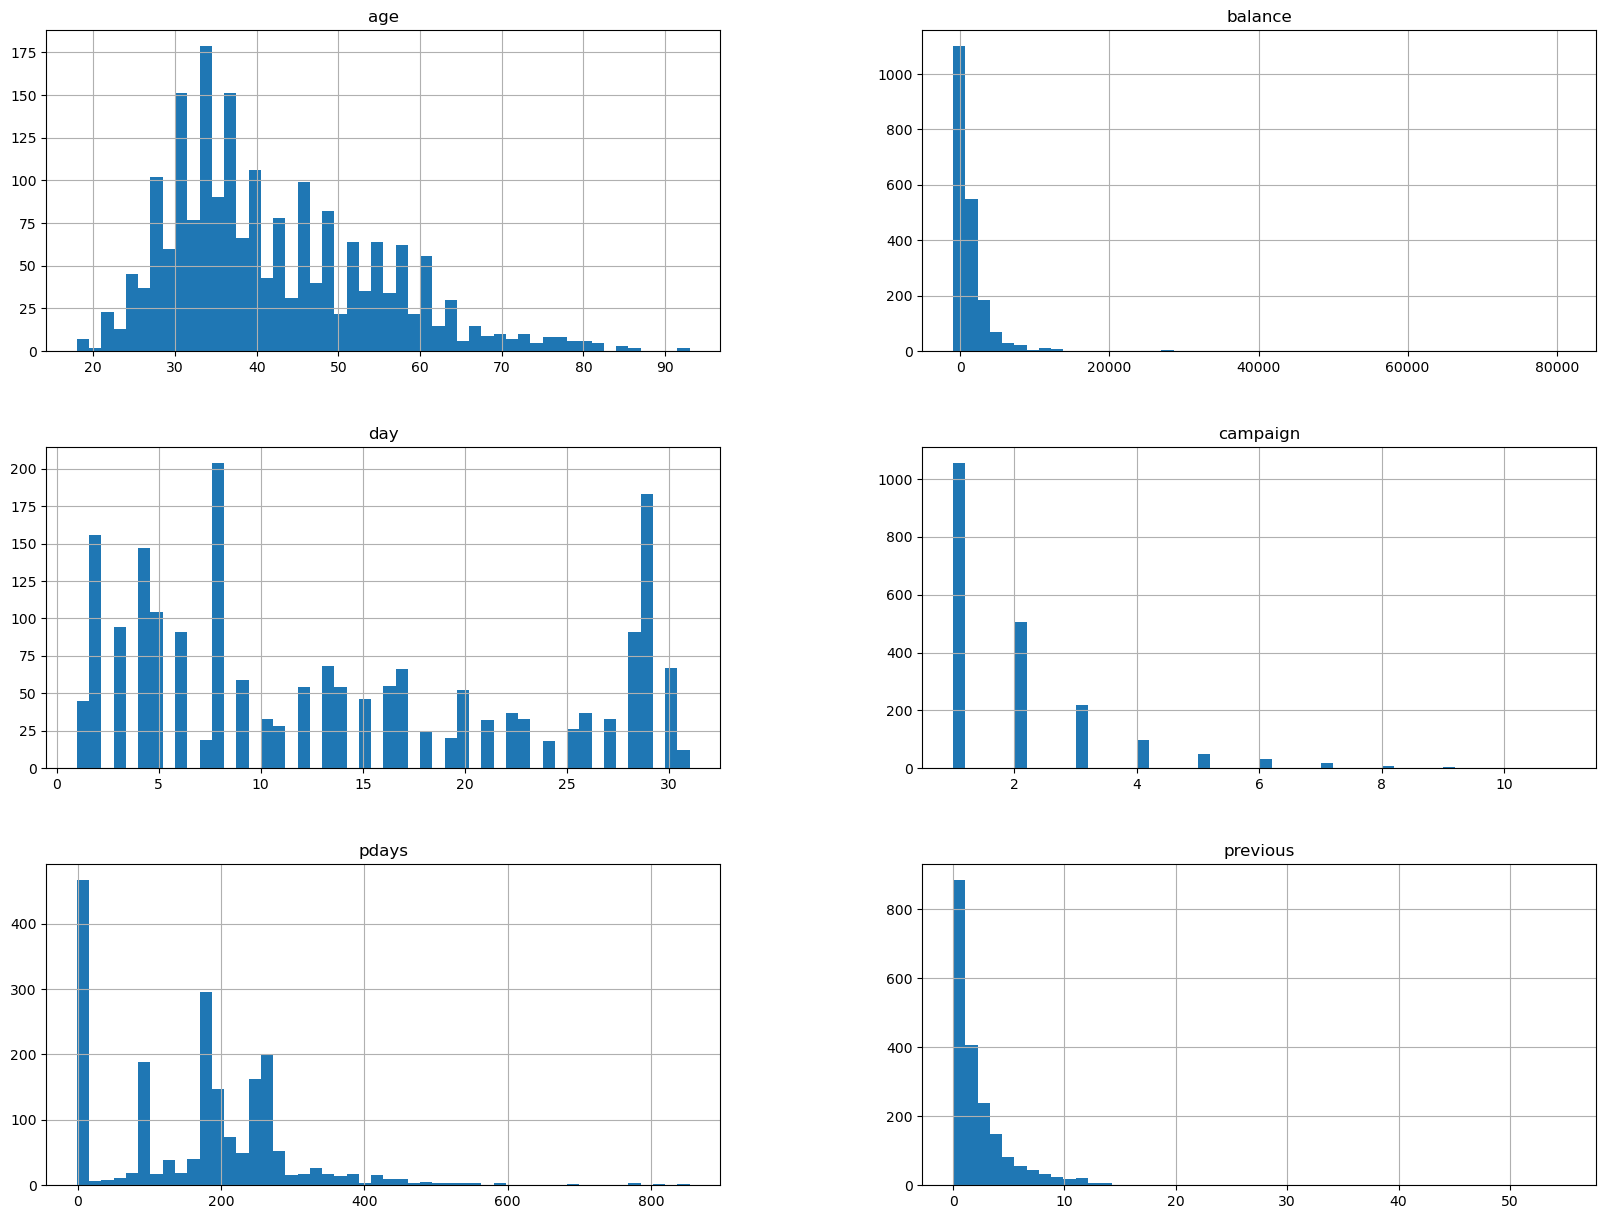

In [10]:
df.hist(bins=50, figsize=(20, 15))

<Axes: >

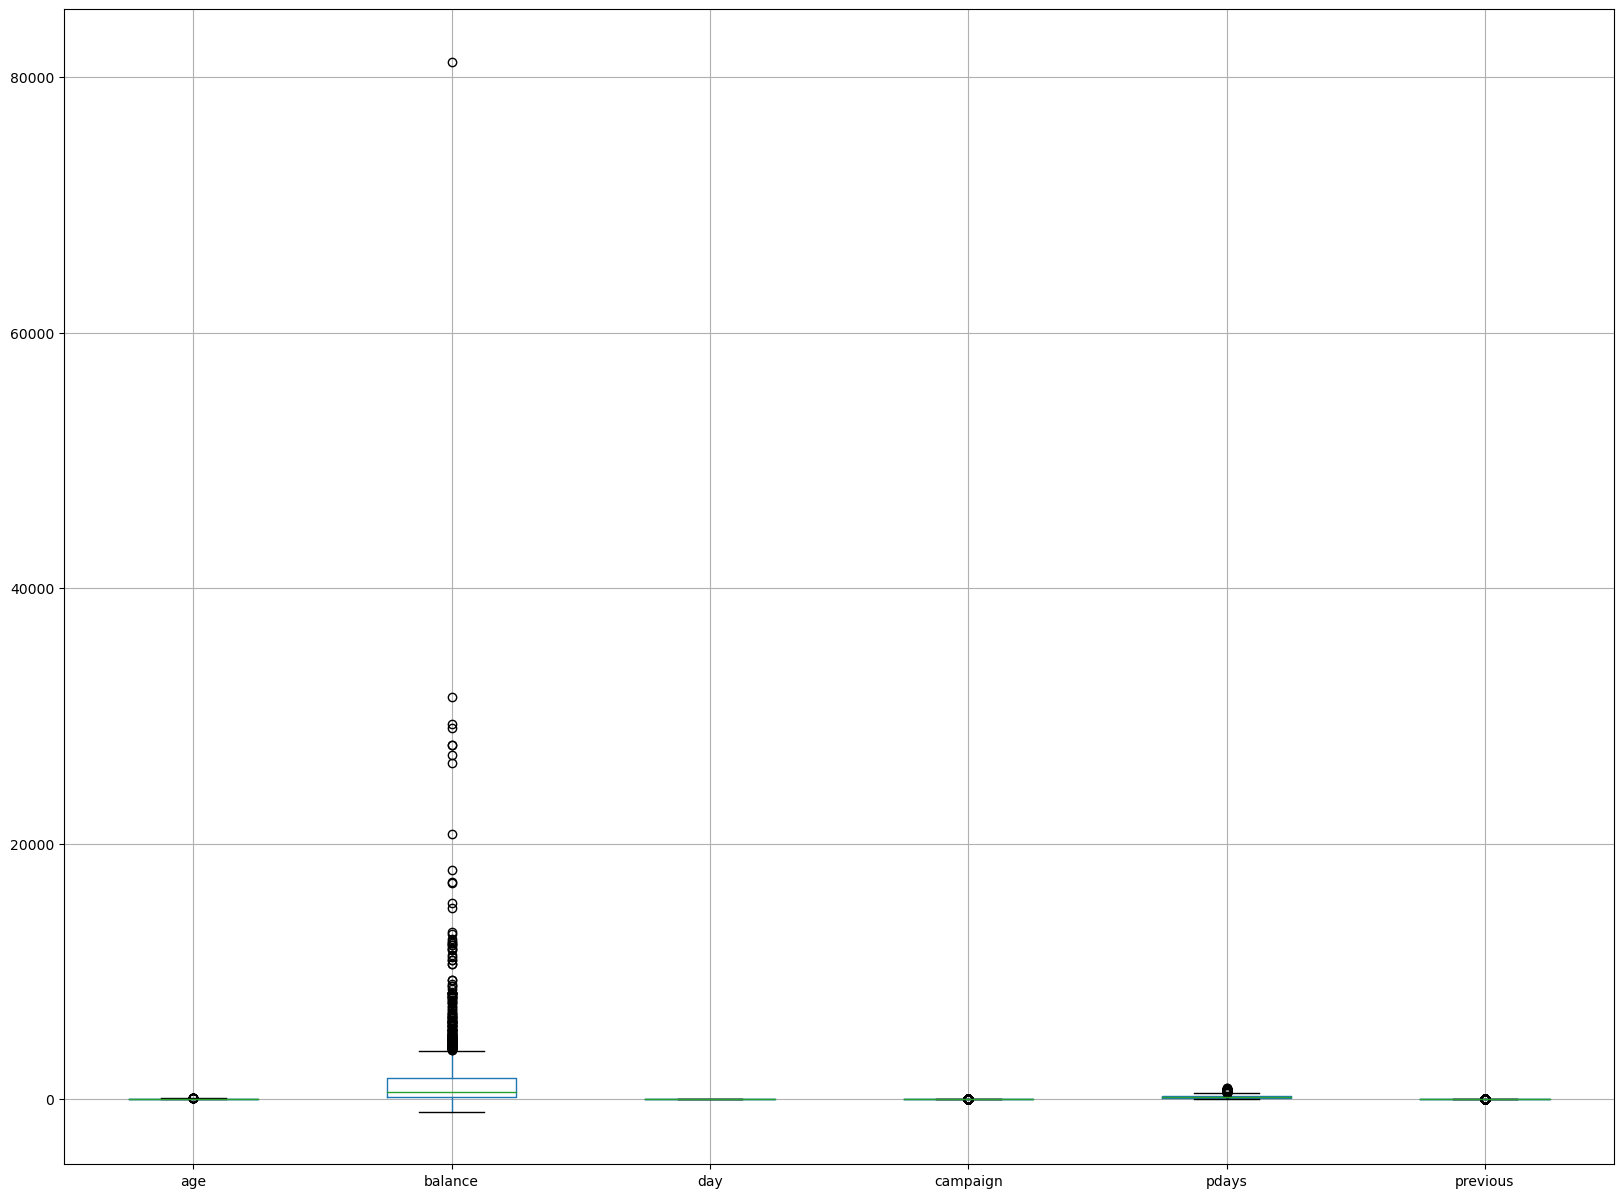

In [11]:
df.boxplot(figsize=(20, 15))

In [12]:
class CyclicalTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to convert cyclical features into sine and cosine components.
    """

    def __init__(self, columns, max_values):
        self.columns = columns
        self.max_values = max_values

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        for i, col in enumerate(self.columns):
            # Get the maximum value of the column if provided, otherwise use the column's max value
            max_value = self.max_values[i] if self.max_values else X[col].max()

            # Create sine and cosine features
            X[f'{col}_sin'] = np.sin(2 * np.pi * X[col] / max_value)
            X[f'{col}_cos'] = np.cos(2 * np.pi * X[col] / max_value)
        return X.drop(columns=self.columns, axis=1)
    
class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to apply log transformation to specified columns.
    """

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            # Apply log transformation
            X[col] = np.log1p(X[col] + abs(X[col].min()) + 1)  # To avoid log(0)
        return X

In [13]:
# convert month to numerical values
df['month'] = df['month'].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

# Define the columns to be used for preprocessing
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop duplicate columns
num_cols.remove('day')
num_cols.remove('month')

print(f"Numerical Columns: {num_cols}")
print(f"Categorical Columns: {cat_cols}")

Numerical Columns: ['age', 'balance', 'campaign', 'pdays', 'previous']
Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']


In [14]:
# Define the preprocessing steps for numerical and categorical features
num_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("log", LogTransformer(columns=num_cols)),
        ("scale", StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)
# Imputation means that the contact column will be filled with the most frequent value in the column. I think this is okay for this dataset.

# Define the preprocessing steps for cyclical features (day and month)
cyc_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("scale", CyclicalTransformer(
            columns=["day", "month"],
            max_values=[31, 12]
        )),
    ]
)

# Create the ColumnTransformer to apply the transformations
preprocesser = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
        ("cyc", cyc_transformer, ["day", "month"])
    ],
    remainder="drop"
)

# Set the display mode to show the full pipeline
set_config(display="diagram")

# Create the pipeline with the preprocessing steps
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocesser)
    ]
)

# Display the pipeline
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   LogTransformer(columns=['age',
                                                                                           'balance',
                                                                                           'campaign',
                                                                                           'pdays',
                                                                                           'previous'])),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('cyc',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   CyclicalTransformer(columns=['day',
                                                                                                'month'],
                                                                                       max_values=[31,
                                                                                                   12]))]),
                                                  ['day', 'month'])]))])

In [15]:
# Fit the pipeline and transform the data
prep_df = pipeline.fit_transform(df)

print("Prepared data shape:", prep_df.shape)

print("Number of null values after pipeline:", np.isnan(prep_df).sum())

Prepared data shape: (1988, 40)
Number of null values after pipeline: 0


# Task 2: k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

In [16]:
def plot_K_values(X, max_k=12):
    """
    Plot the elbow method for k-means clustering.
    
    Parameters:
    X (array-like): The input data.
    max_k (int): The maximum number of clusters to test.
    
    Returns:
    None
    """
    k_range = range(2, max_k + 1)
    sse = []
    silhouette_scores = []
    
    
    for k in k_range:
        k_means = KMeans(n_clusters=k, random_state=42, n_init="auto")
        k_means.fit(X)
        sse.append(k_means.inertia_)

    for k in k_range:
        k_means = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = k_means.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        
    # plot the elbow method and silhouette scores on same plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(k_range, sse, 'g-', label='SSE', marker='o')
    ax2.plot(k_range, silhouette_scores, 'b-', label='Silhouette Score', marker='o')

    fig.legend()
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('SSE', color='g')
    ax2.set_ylabel('Silhouette Score', color='b')
    ax1.set_title('Elbow Method and Silhouette Score')
    ax1.grid(True)
    plt.show()

def plot_mds_tsne(X_mds, X_tsne, cluster_labels, k_means=None):
    """
    Plot MDS and t-SNE visualizations.

    Parameters:
    X_mds (array-like): MDS transformed data.
    X_tsne (array-like): t-SNE transformed data.
    cluster_labels (array-like): Cluster labels.

    Returns:
    None
    """
    plt.figure(figsize=(12, 16))

    # MDS plot
    plt.subplot(2, 1, 1)
    for i in np.unique(cluster_labels):
        if i == -1:
            plt.scatter(X_mds[cluster_labels == i, 0], X_mds[cluster_labels == i, 1], s=10, c='gray', label='Noise')
        else:
            plt.scatter(X_mds[cluster_labels == i, 0], X_mds[cluster_labels == i, 1], s=10, label=f'Cluster {i}')
    # Plot the centers of the clusters if k_means is provided
    if k_means is not None:
        k_means.fit(X_mds)
        centers = k_means.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='X', label='Centroids')
    
    # add clusters to the legend with name and color
    plt.legend()
    plt.title('MDS Visualization')
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.grid(True)

    # t-SNE plot
    plt.subplot(2, 1, 2)
    for i in np.unique(cluster_labels):
        if i == -1:
            plt.scatter(X_mds[cluster_labels == i, 0], X_mds[cluster_labels == i, 1], s=5, c='gray', label='Noise')
        else:
            plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], s=5, label=f'Cluster {i}')
    # Plot the centers of the clusters if k_means is provided
    if k_means is not None:
        k_means.fit(X_tsne)
        centers = k_means.cluster_centers_
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='X', label='Centroids')
    plt.legend()
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

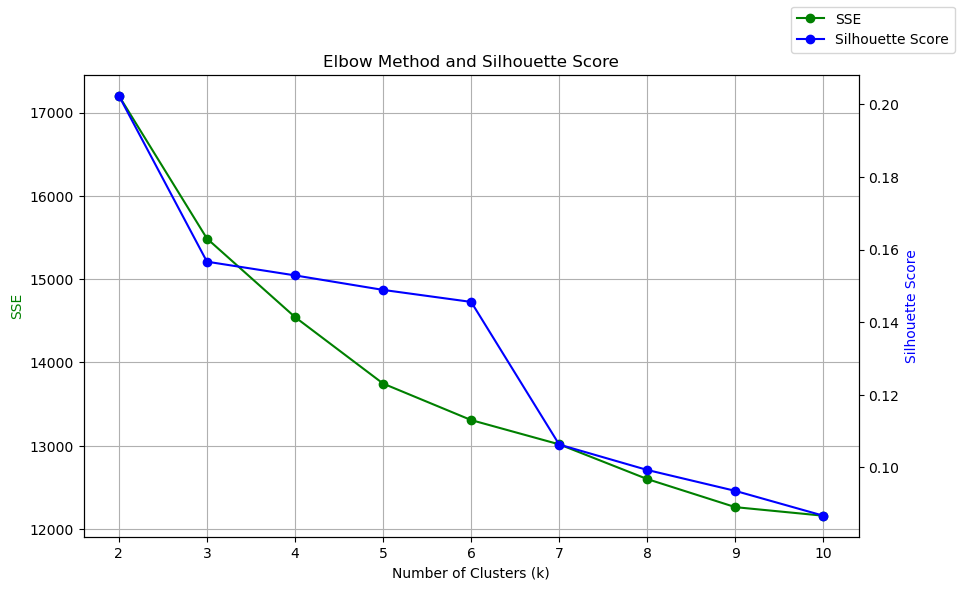

In [17]:
# Call the function to plot the elbow method and silhouette scores
plot_K_values(prep_df, max_k=10)

In [18]:
# Reduce dimensions using PCA
pca = PCA(n_components=2, random_state=42)
prep_df_pca = pca.fit_transform(prep_df)

In [19]:
# Choose the second best k value based on the elbow method and silhouette score
best_k = 5

# Perform k-means clustering with the best k value
k_means = KMeans(n_clusters=best_k, random_state=42, n_init="auto", max_iter=1500)
cluster_labels = k_means.fit_predict(prep_df)

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(prep_df, cluster_labels)
print(f"Silhouette Score for k={best_k}: {silhouette_avg:.2f}")

# Add the cluster labels to the original dataframe
df['cluster'] = cluster_labels

Silhouette Score for k=5: 0.15


In [20]:
# Calculate MDS
mds = MDS(n_components=2, random_state=42, n_init=4, normalized_stress="auto", n_jobs=-1)
X_mds = mds.fit_transform(prep_df_pca) # Using PCA transformed data for MDS to reduce computation time

In [21]:
# Calculate t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000, init="pca")
X_tsne = tsne.fit_transform(prep_df)

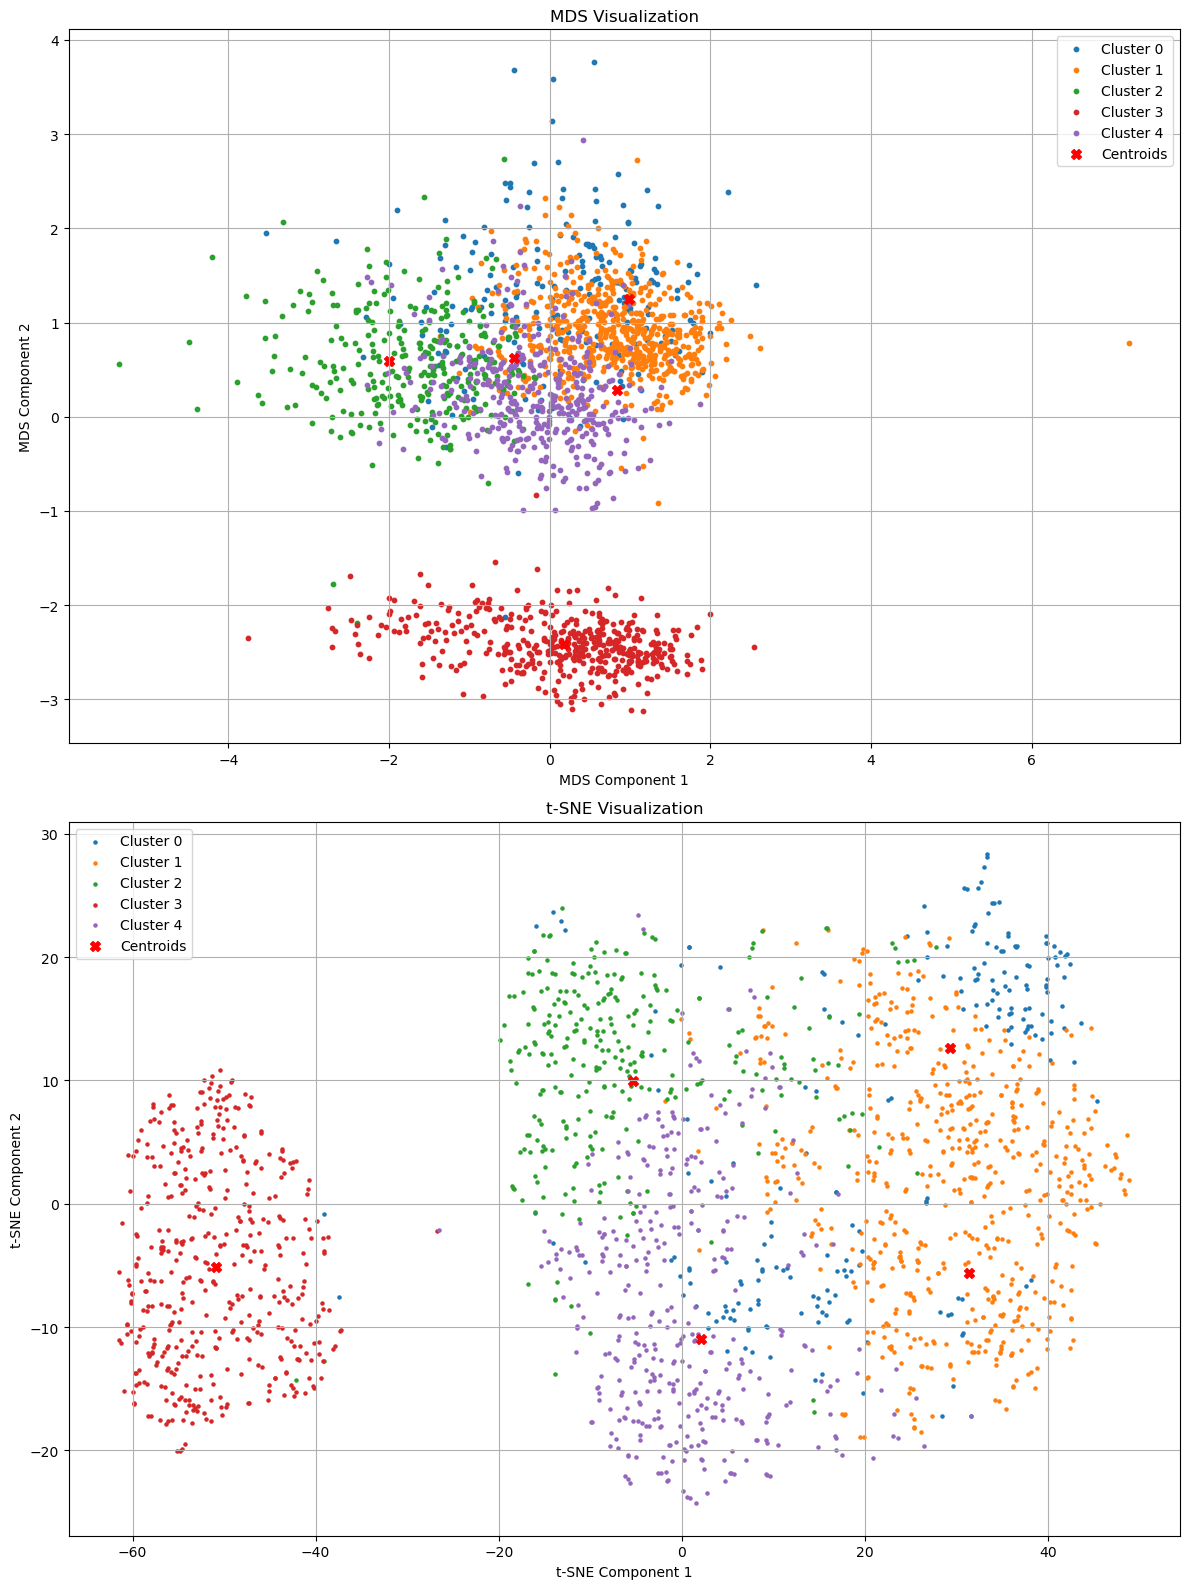

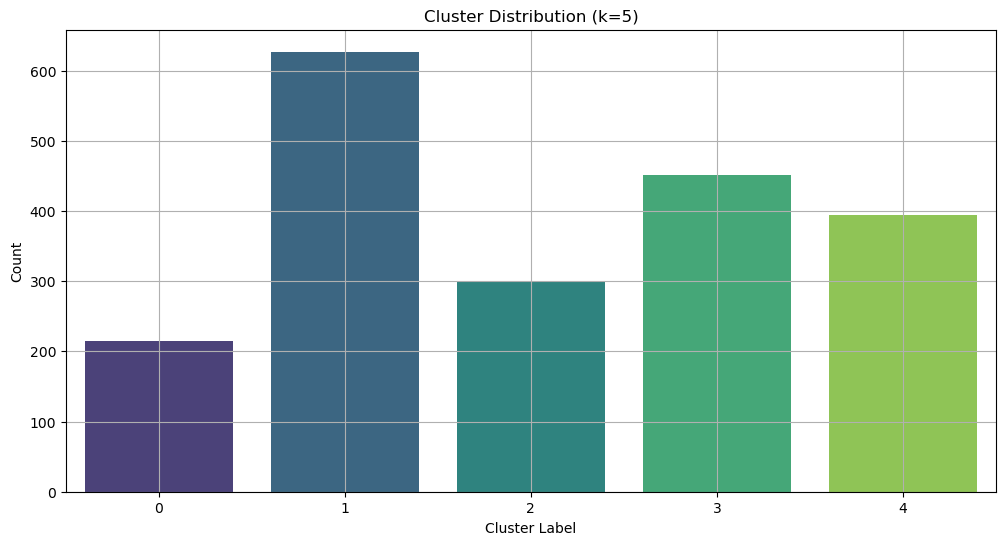

In [22]:
# Plot MDS and t-SNE visualizations
plot_mds_tsne(X_mds, X_tsne, cluster_labels, k_means=k_means)

# Plot the distribution of the clusters in the original data
plt.figure(figsize=(12, 6))
sn.countplot(data=df, x='cluster', palette='viridis')
plt.title(f'Cluster Distribution (k={k_means.n_clusters})')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.grid(True)

In [23]:
# Choose the best k value based on the elbow method and silhouette score
best_k = 6

# Perform k-means clustering with the best k value
k_means = KMeans(n_clusters=best_k, random_state=42, n_init="auto", max_iter=1500)
cluster_labels = k_means.fit_predict(prep_df)

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(prep_df, cluster_labels)
print(f"Silhouette Score for k={best_k}: {silhouette_avg:.2f}")

# Add the cluster labels to the original dataframe
df['cluster'] = cluster_labels

Silhouette Score for k=6: 0.15


In [24]:
# Calculate MDS
mds = MDS(n_components=2, random_state=42, n_init=4, normalized_stress="auto", n_jobs=-1)
X_mds = mds.fit_transform(prep_df_pca) # Using PCA transformed data for MDS to reduce computation time

In [25]:
# Calculate t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000, init="pca")
X_tsne = tsne.fit_transform(prep_df)

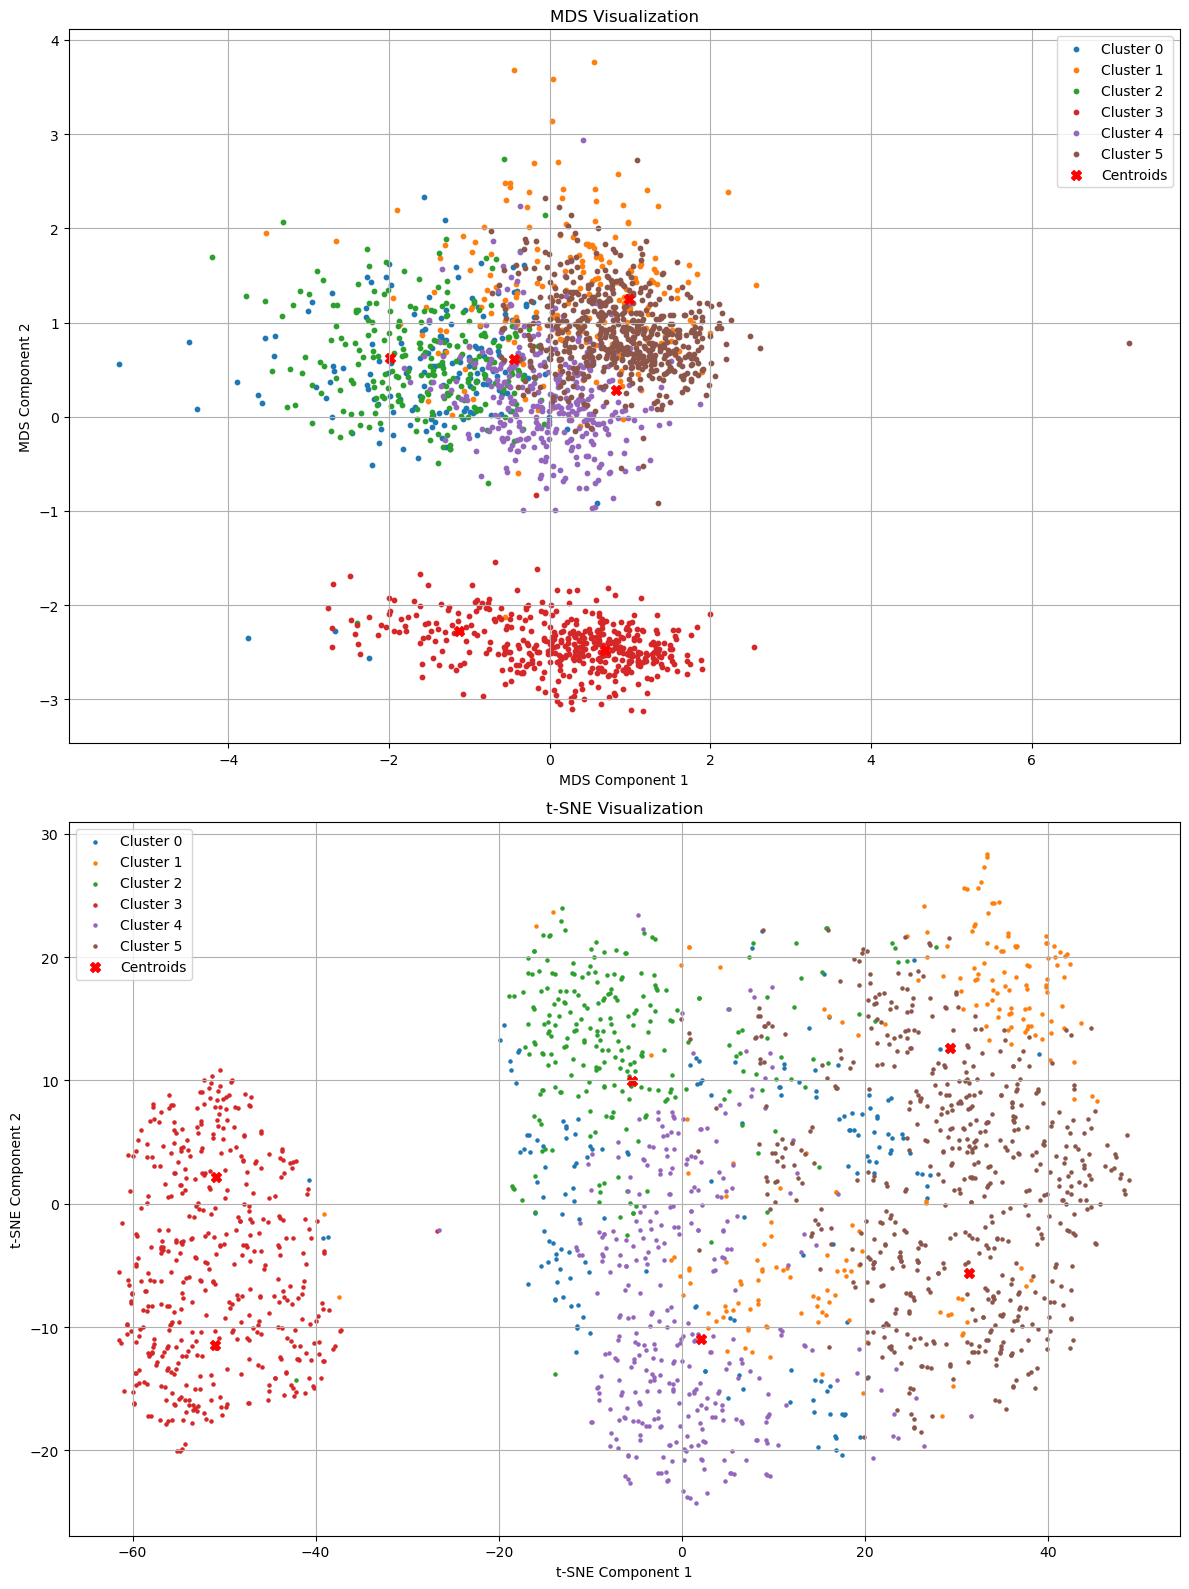

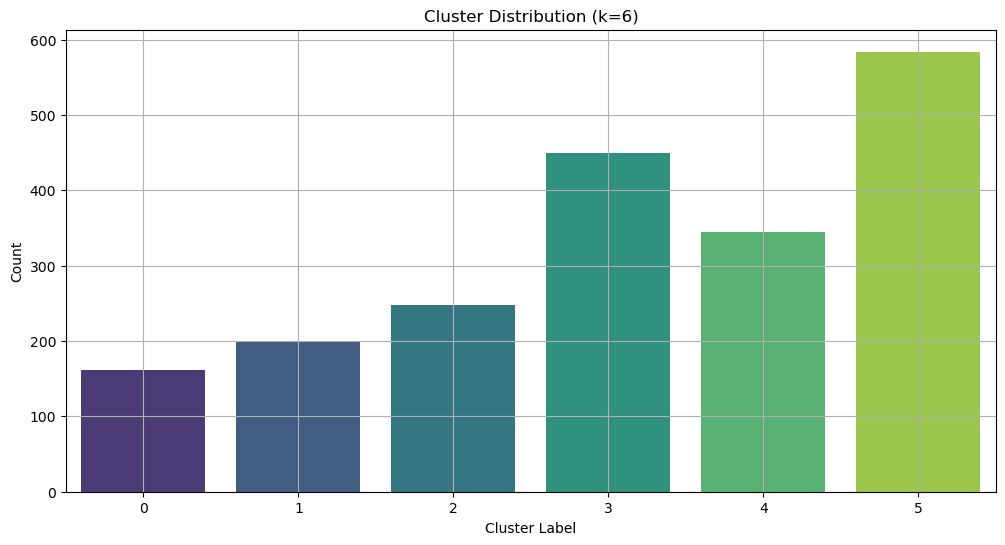

In [26]:
# Plot MDS and t-SNE visualizations
plot_mds_tsne(X_mds, X_tsne, cluster_labels, k_means=k_means)

# Plot the distribution of the clusters in the original data
plt.figure(figsize=(12, 6))
sn.countplot(data=df, x='cluster', palette='viridis')
plt.title(f'Cluster Distribution (k={k_means.n_clusters})')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.grid(True)

In [27]:
df["cluster"].value_counts()

5    584
3    450
4    345
2    248
1    200
0    161
Name: cluster, dtype: int64

In [28]:
df.groupby("cluster").describe().transpose()[:32]

cluster                   0            1            2             3  \
age     count    161.000000   200.000000   248.000000    450.000000   
        mean      43.596273    40.050000    60.717742     39.297778   
        std       10.885988     9.819860    10.419586     12.937411   
        min       26.000000    21.000000    41.000000     18.000000   
        25%       35.000000    32.000000    53.000000     30.000000   
        50%       41.000000    38.000000    60.000000     36.000000   
        75%       52.000000    47.000000    67.000000     46.000000   
        max       84.000000    67.000000    93.000000     86.000000   
balance count    161.000000   200.000000   248.000000    450.000000   
        mean    7211.422360   865.070000  1488.040323   1104.577778   
        std     8264.639359  1171.016208  1482.903329   1667.391871   
        min     1707.000000  -735.000000     0.000000   -768.000000   
        25%     3301.000000   189.000000   368.000000    139.250000   
        50%     4629.000000   474.000000  1024.000000    471.500000   
        75%     7780.000000  1139.250000  2071.000000   1348.000000   
        max    81204.000000  6809.000000  8304.000000  12264.000000   
day     count    161.000000   200.000000   248.000000    450.000000   
        mean      15.745342    12.405000    15.842742     12.662222   
        std       10.274531    10.106517     7.574426      7.609726   
        min        1.000000     1.000000     1.000000      1.000000   
        25%        5.000000     4.000000    11.000000      8.000000   
        50%       15.000000     9.000000    15.000000      8.000000   
        75%       26.000000    20.000000    22.000000     17.000000   
        max       31.000000    31.000000    31.000000     31.000000   
month   count    161.000000   200.000000   248.000000    450.000000   
        mean       5.745342     3.610000     7.145161      5.984444   
        std        3.265883     2.824498     2.600821      1.966813   
        min        1.000000     1.000000     1.000000      3.000000   
        25%        3.000000     2.000000     5.000000      5.000000   
        50%        5.000000     2.000000     7.000000      5.000000   
        75%        8.000000     5.000000     9.000000      7.000000   
        max       12.000000    12.000000    12.000000     11.000000   

cluster                  4            5  
age     count   345.000000   584.000000  
        mean     32.353623    41.219178  
        std       5.957421     8.854062  
        min      19.000000    24.000000  
        25%      28.000000    34.000000  
        50%      32.000000    39.000000  
        75%      36.000000    48.000000  
        max      51.000000    60.000000  
balance count   345.000000   584.000000  
        mean    928.078261   505.388699  
        std     930.446981   609.835575  
        min    -205.000000  -980.000000  
        25%     222.000000   104.500000  
        50%     560.000000   363.000000  
        75%    1477.000000   688.000000  
        max    5169.000000  3322.000000  
day     count   345.000000   584.000000  
        mean     13.849275    13.792808  
        std       8.098981    12.023414  
        min       1.000000     1.000000  
        25%       7.000000     3.000000  
        50%      13.000000     6.000000  
        75%      20.000000    29.000000  
        max      31.000000    31.000000  
month   count   345.000000   584.000000  
        mean      7.295652     2.291096  
        std       2.207179     1.982995  
        min       1.000000     1.000000  
        25%       6.000000     1.000000  
        50%       7.000000     2.000000  
        75%       9.000000     2.000000  
        max      12.000000    12.000000

In [29]:
df.groupby("cluster").describe().transpose()[32:]

cluster                  0           1           2           3           4  \
campaign count  161.000000  200.000000  248.000000  450.000000  345.000000   
         mean     1.857143    4.700000    1.540323    1.762222    1.513043   
         std      1.088905    1.683500    0.898935    1.128254    0.743560   
         min      1.000000    2.000000    1.000000    1.000000    1.000000   
         25%      1.000000    3.000000    1.000000    1.000000    1.000000   
         50%      2.000000    4.000000    1.000000    1.000000    1.000000   
         75%      2.000000    6.000000    2.000000    2.000000    2.000000   
         max      7.000000   11.000000    6.000000    8.000000    4.000000   
pdays    count  161.000000  200.000000  248.000000  450.000000  345.000000   
         mean   198.279503  224.635000  177.322581   -0.991111  216.878261   
         std    114.253786   90.677194  105.806871    0.133185  153.451387   
         min     -1.000000   -1.000000   -1.000000   -1.000000    1.000000   
         25%    101.000000  182.750000   93.750000   -1.000000   93.000000   
         50%    184.000000  227.000000  181.000000   -1.000000  182.000000   
         75%    245.000000  265.000000  185.000000   -1.000000  276.000000   
         max    784.000000  776.000000  792.000000    1.000000  854.000000   
previous count  161.000000  200.000000  248.000000  450.000000  345.000000   
         mean     3.105590    5.265000    3.939516    0.006667    3.605797   
         std      2.728558    6.557421    3.052902    0.105315    3.293046   
         min      0.000000    0.000000    0.000000    0.000000    1.000000   
         25%      1.000000    2.000000    2.000000    0.000000    2.000000   
         50%      2.000000    4.000000    3.000000    0.000000    3.000000   
         75%      4.000000    6.000000    5.000000    0.000000    4.000000   
         max     14.000000   55.000000   20.000000    2.000000   27.000000   

cluster                  5  
campaign count  584.000000  
         mean     1.453767  
         std      0.592624  
         min      1.000000  
         25%      1.000000  
         50%      1.000000  
         75%      2.000000  
         max      3.000000  
pdays    count  584.000000  
         mean   237.138699  
         std     69.043822  
         min      1.000000  
         25%    197.750000  
         50%    246.000000  
         75%    264.000000  
         max    842.000000  
previous count  584.000000  
         mean     2.258562  
         std      1.829788  
         min      1.000000  
         25%      1.000000  
         50%      2.000000  
         75%      3.000000  
         max     23.000000

In [30]:
df.groupby('cluster').describe(include='object').transpose() 

cluster                    0           1          2           3           4  \
job       count          161         200        248         450         345   
          unique          11          11         11          12          11   
          top     management  management    retired  management  management   
          freq            65          52         97          88         104   
marital   count          161         200        248         450         345   
          unique           3           3          3           3           3   
          top        married     married    married     married      single   
          freq           106         108        209         215         226   
education count          161         200        248         450         345   
          unique           4           4          4           4           4   
          top       tertiary   secondary  secondary   secondary    tertiary   
          freq            80         100        129         213         172   
default   count          161         200        248         450         345   
          unique           1           2          1           2           2   
          top             no          no         no          no          no   
          freq           161         197        248         446         343   
housing   count          161         200        248         450         345   
          unique           2           2          2           2           2   
          top             no         yes         no          no          no   
          freq           104         123        210         258         262   
loan      count          161         200        248         450         345   
          unique           2           2          2           2           2   
          top             no          no         no          no          no   
          freq           147         169        233         418         328   
contact   count          161         200        247         266         341   
          unique           2           2          2           2           2   
          top       cellular    cellular   cellular    cellular    cellular   
          freq           151         179        201         240         325   
poutcome  count          161         200        248         450         345   
          unique           4           4          4           2           3   
          top        failure     failure    success     unknown     success   
          freq            84         149        163         448         199   

cluster                    5  
job       count          584  
          unique          12  
          top     technician  
          freq           137  
marital   count          584  
          unique           3  
          top        married  
          freq           359  
education count          584  
          unique           4  
          top      secondary  
          freq           344  
default   count          584  
          unique           2  
          top             no  
          freq           579  
housing   count          584  
          unique           2  
          top            yes  
          freq           464  
loan      count          584  
          unique           2  
          top             no  
          freq           445  
contact   count          582  
          unique           2  
          top       cellular  
          freq           556  
poutcome  count          584  
          unique           3  
          top        failure  
          freq           567

The results above show that the optimal K value is 6. It can be seen that the Elbow curve takes a er decline at k=6 and the Silhouette score peaks at the same value. I did plot the MDS and t-SNE graphs for k=5 and k=6. It is clear that K=6 produces better clusters.

The MDS plot shows that there is considerable overlap in all the clusters except the cluster 3(red). A MDS plot tries to preserve the distance between all points faithfully in 2D, this projection of the high dimensional bank data shows that there is not a perfect distinction between the data.

In the t-SNE plot the six clusters are sparsely spread out and poorly separated, except for cluster 3 (red) again. A dense clusters of data indicate that the points within the clusters are highly similar to each other in original space. Therefore we can determine that some clusters are not completely distinguishable in original space.

Analysing the resulting cluster in terms of the original data we see the following:
- Cluster 0 – Middle-aged (avg. 43.6), high balance (avg. 7.2k), mostly in management, many with tertiary education, rarely contacted before (low previous), and mostly no housing loans.
- Cluster 1 – Slightly younger (avg. 40.0), low balance (avg. 865), high campaign contacts (avg. 4.7), mostly married and in management, high number of previous contacts.
- Cluster 2 – Older group (avg. 60.7), decent balance (avg. 1.5k), mostly retired, high success rate from past campaigns, very low campaign count.
- Cluster 3 – Younger (avg. 39.3), low balance (avg. 1.1k), minimal previous contacts, mainly contacted only once (pdays = -1), mostly married with secondary education.
- Cluster 4 – Youngest cluster (avg. 32.4), modest balance (avg. 928), very high number of singles, strong past success, mostly without housing or loans.
- Cluster 5 – Broad age range (avg. 41.2), lowest balance (avg. 505), highly contacted previously (high pdays & previous), mostly technicians, generally contacted via cellular.

# Task 3: DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering. Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

 0    1301
 1     407
-1     277
 2       3
Name: dbscan_cluster, dtype: int64


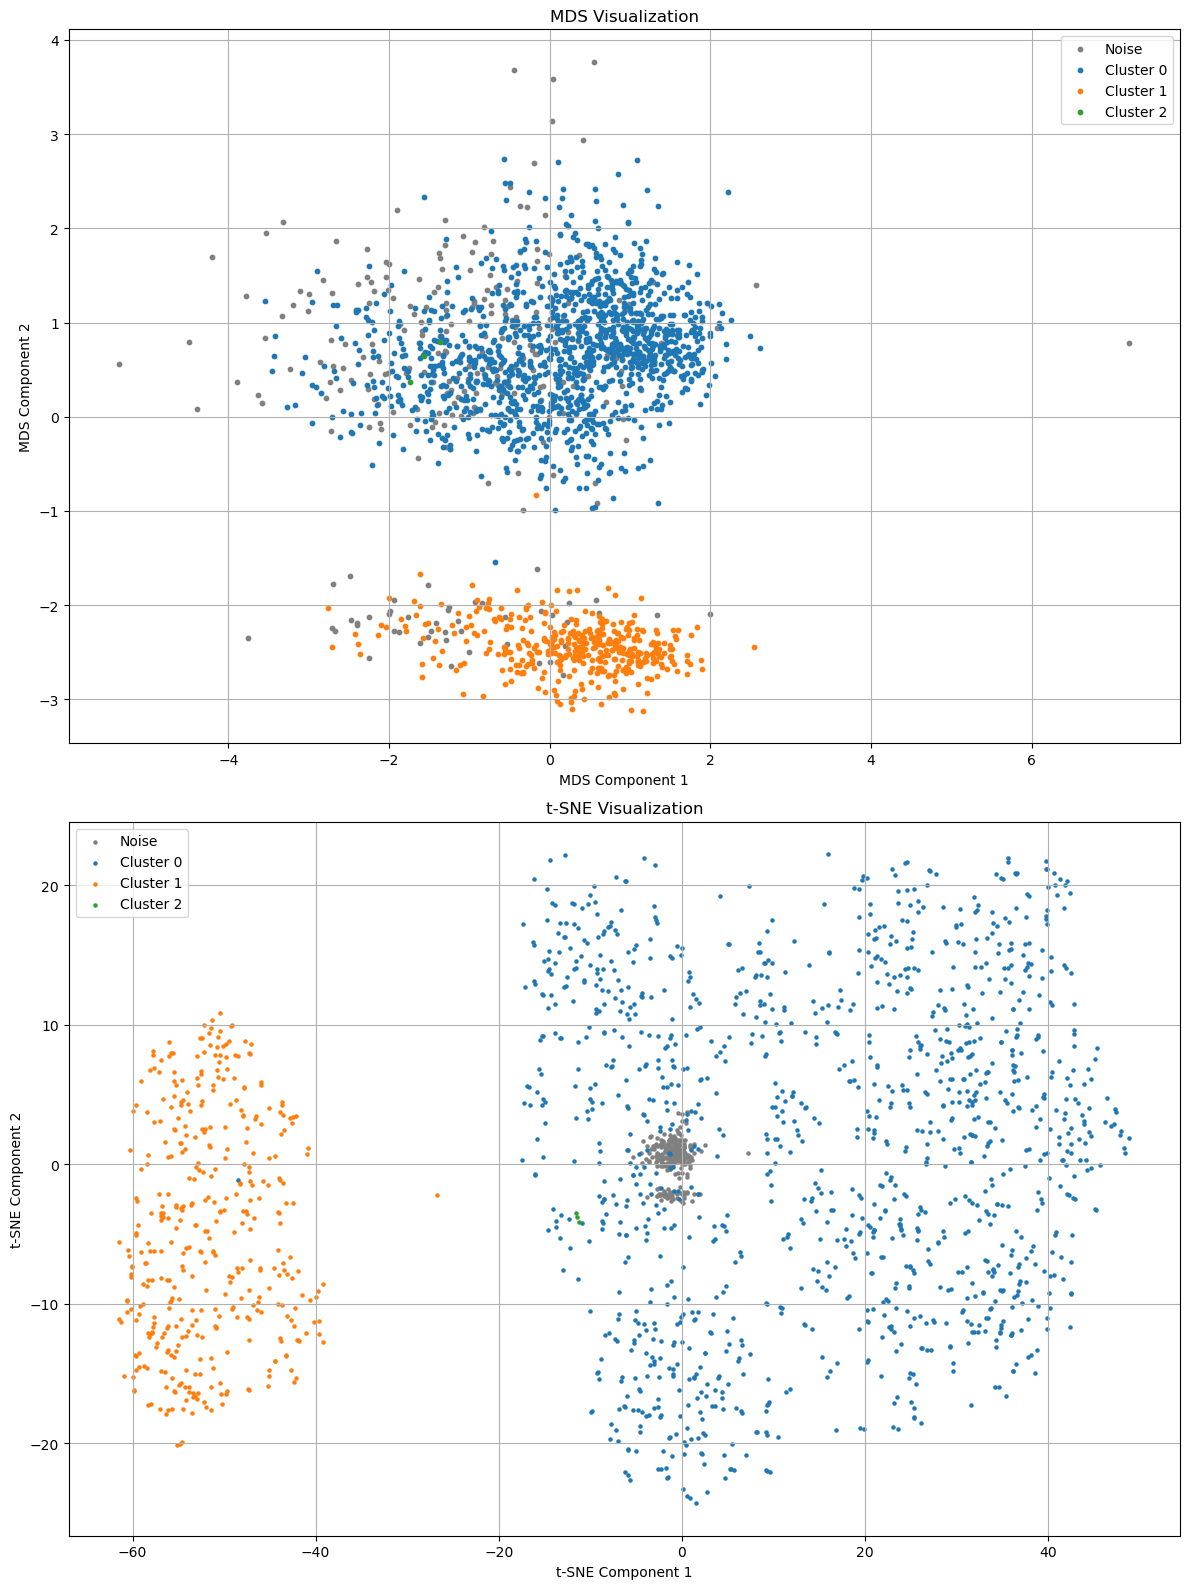

In [31]:
# Apply DBSCAN clustering
eps = 2.35
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(prep_df)

df['dbscan_cluster'] = dbscan_labels

print(df["dbscan_cluster"].value_counts())

# Plot MDS and t-SNE visualizations for DBSCAN
plot_mds_tsne(X_mds, X_tsne, dbscan_labels)

In [32]:
df.groupby("dbscan_cluster").describe().transpose()[:32]

dbscan_cluster            -1             0             1            2
age     count     277.000000   1301.000000    407.000000     3.000000
        mean       47.270758     41.759416     38.036855    33.666667
        std        15.717005     11.824736     11.900909     2.309401
        min        21.000000     19.000000     18.000000    31.000000
        25%        34.000000     33.000000     30.000000    33.000000
        50%        45.000000     39.000000     35.000000    35.000000
        75%        57.000000     49.000000     44.000000    35.000000
        max        93.000000     86.000000     78.000000    35.000000
balance count     277.000000   1301.000000    407.000000     3.000000
        mean     3861.285199   1032.611837    969.285012  2659.333333
        std      7152.306715   1435.910542   1450.652394   229.072769
        min      -980.000000   -676.000000   -744.000000  2427.000000
        25%       429.000000    203.000000    131.500000  2546.500000
        50%      1760.000000    502.000000    442.000000  2666.000000
        75%      4401.000000   1333.000000   1210.500000  2775.500000
        max     81204.000000  10861.000000  12264.000000  2885.000000
day     count     277.000000   1301.000000    407.000000     3.000000
        mean       15.722022     13.856264     12.434889    11.000000
        std         9.013194     10.353079      7.569387     2.645751
        min         1.000000      1.000000      1.000000     8.000000
        25%         8.000000      4.000000      8.000000    10.000000
        50%        16.000000     12.000000      8.000000    12.000000
        75%        23.000000     25.000000     16.000000    12.500000
        max        31.000000     31.000000     31.000000    13.000000
month   count     277.000000   1301.000000    407.000000     3.000000
        mean        6.357401      4.451960      5.877150     7.333333
        std         2.979165      3.243010      1.905306     0.577350
        min         1.000000      1.000000      3.000000     7.000000
        25%         4.000000      2.000000      5.000000     7.000000
        50%         7.000000      4.000000      5.000000     7.000000
        75%         9.000000      7.000000      7.000000     7.500000
        max        12.000000     12.000000     11.000000     8.000000

In [33]:
df.groupby("dbscan_cluster").describe().transpose()[32:]

dbscan_cluster          -1            0           1           2
campaign count  277.000000  1301.000000  407.000000    3.000000
         mean     2.898917     1.771714    1.643735    2.666667
         std      2.068719     1.186202    0.940786    0.577350
         min      1.000000     1.000000    1.000000    2.000000
         25%      1.000000     1.000000    1.000000    2.500000
         50%      2.000000     1.000000    1.000000    3.000000
         75%      4.000000     2.000000    2.000000    3.000000
         max     11.000000    11.000000    5.000000    3.000000
pdays    count  277.000000  1301.000000  407.000000    3.000000
         mean   171.133574   220.095311   -0.995086  116.333333
         std    143.557165   102.978184    0.099136   63.705050
         min     -1.000000     1.000000   -1.000000   43.000000
         25%     89.000000   181.000000   -1.000000   95.500000
         50%    179.000000   205.000000   -1.000000  148.000000
         75%    213.000000   262.000000   -1.000000  153.000000
         max    776.000000   854.000000    1.000000  158.000000
previous count  277.000000  1301.000000  407.000000    3.000000
         mean     4.613718     2.914681    0.004914    8.000000
         std      6.486236     2.384167    0.099136    1.000000
         min      0.000000     1.000000    0.000000    7.000000
         25%      1.000000     1.000000    0.000000    7.500000
         50%      3.000000     2.000000    0.000000    8.000000
         75%      6.000000     4.000000    0.000000    8.500000
         max     55.000000    23.000000    2.000000    9.000000
cluster  count  277.000000  1301.000000  407.000000    3.000000
         mean     1.916968     3.521906    3.000000    4.000000
         std      1.516922     1.723285    0.000000    0.000000
         min      0.000000     0.000000    3.000000    4.000000
         25%      1.000000     2.000000    3.000000    4.000000
         50%      2.000000     4.000000    3.000000    4.000000
         75%      3.000000     5.000000    3.000000    4.000000
         max      5.000000     5.000000    3.000000    4.000000

In [34]:
df.groupby('cluster').describe(include='object').transpose() 

cluster                    0           1          2           3           4  \
job       count          161         200        248         450         345   
          unique          11          11         11          12          11   
          top     management  management    retired  management  management   
          freq            65          52         97          88         104   
marital   count          161         200        248         450         345   
          unique           3           3          3           3           3   
          top        married     married    married     married      single   
          freq           106         108        209         215         226   
education count          161         200        248         450         345   
          unique           4           4          4           4           4   
          top       tertiary   secondary  secondary   secondary    tertiary   
          freq            80         100        129         213         172   
default   count          161         200        248         450         345   
          unique           1           2          1           2           2   
          top             no          no         no          no          no   
          freq           161         197        248         446         343   
housing   count          161         200        248         450         345   
          unique           2           2          2           2           2   
          top             no         yes         no          no          no   
          freq           104         123        210         258         262   
loan      count          161         200        248         450         345   
          unique           2           2          2           2           2   
          top             no          no         no          no          no   
          freq           147         169        233         418         328   
contact   count          161         200        247         266         341   
          unique           2           2          2           2           2   
          top       cellular    cellular   cellular    cellular    cellular   
          freq           151         179        201         240         325   
poutcome  count          161         200        248         450         345   
          unique           4           4          4           2           3   
          top        failure     failure    success     unknown     success   
          freq            84         149        163         448         199   

cluster                    5  
job       count          584  
          unique          12  
          top     technician  
          freq           137  
marital   count          584  
          unique           3  
          top        married  
          freq           359  
education count          584  
          unique           4  
          top      secondary  
          freq           344  
default   count          584  
          unique           2  
          top             no  
          freq           579  
housing   count          584  
          unique           2  
          top            yes  
          freq           464  
loan      count          584  
          unique           2  
          top             no  
          freq           445  
contact   count          582  
          unique           2  
          top       cellular  
          freq           556  
poutcome  count          584  
          unique           3  
          top        failure  
          freq           567

For the DBSCAN, it took a lot of trial an error to choose the eps value. I am still very unsure as to what 'good' parameters for the DBSCAN would show. From the current results, this is my current understanding of the data and the clusters.

- Cluster -1(Noise) - Older individuals (avg age 47), high balance (€3.8k), high prior contact, mostly had previous campaigns with some success or failure outcomes — likely outliers or distinct cases.
- Cluster 0 - Mid-aged group (42), moderate balance (€1k), had previous contacts, most common job is management, and contacted mainly via cellular — broadly targeted, possibly frequent contacts.
- Cluster 1 - Youngest group (38), lower balance (€970), almost no prior contact (pdays = -1), mostly retired or married, contacted via cellular — likely new or first-time contacts.
- Cluster 2 - Very small group (n=3), low variance, all aged 34 with relatively high balance (€2.6k) and high prior contact — possibly a tightly knit, high-value client segment.

It was really difficult to determine a clear distinction between each group. Comparing these outlines of what type information we have about each cluster in the DBSCAN and the K-Means clustering it is clear the k-means clustering is more effective and shows clearer separation in the original data space.

# Conclusion
This Etivity was very intersting I learnt a lot about creating pipelines and using K-Means clustering to analyse the data to determine if there are clear lines of separation in the original data that can't be viewed easily without performing this analysis. 

I am somewhat unsure about using the DBSCAN to analyse the data. I seen that in my peers solutions a lot of people struggled to find meaningful results with the DBSCAN. When the majority of people struggled I am wondering does this mean if we are all missing some crucial data preparation step which is specific to this data or if the dimensionality of the data is too high as suggested by some classmates.

I learnt a lot from the Discussion forums for this project, my pipeline took a lot of inspiration from Christos Koutsiaris' solution. I had a different solution but originally but after some analysis of my peers I have altered it to take a few different techniques from my peers. I used the imputer to impute data rather than performing this manually. I also simplified which columns are transformed and how they are transformed. I think this makes it easier to follow now. I found visualising the pipeline to be really helpful in understanding the flow and ensuring there is not duplication of steps.